In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!cp -R '/content/drive/MyDrive/Colab Notebooks/Project/noise-reducer-ml/Dataset/' /content

In [4]:
!rm -r /content/tfrecords/outputs

In [2]:
%cd '/content/drive/MyDrive/Colab Notebooks/Project/noise-reducer-ml/denoiser-inverse'

/content/drive/MyDrive/Colab Notebooks/Project/noise-reducer-ml/denoiser-inverse


In [3]:
!cp -R '/content/drive/MyDrive/tfrecords' /content

In [5]:
import os
import tensorflow as tf
from IPython.display import Audio
from denoiser.augment import augment

AUTOTUNE = tf.data.experimental.AUTOTUNE

In [6]:
def _parse_batch(record_batch, sample_rate, duration, split):
	n_samples = sample_rate * duration

	# Create a description of the features
	feature_description = {
		'noisy': tf.io.FixedLenFeature([n_samples], tf.float32),
		'clean': tf.io.FixedLenFeature([n_samples], tf.float32),
	}
	# Parse the input `tf.Example` proto using the dictionary above
	example = tf.io.parse_example(record_batch, feature_description)
	noisy, clean = tf.expand_dims(example['noisy'], axis=-1), tf.expand_dims(example['clean'], axis=-1)
	if split == 'train':
		noisy, clean = augment(noisy, clean)
	return noisy, clean
	# return clean, noisy


In [17]:
def get_dataset_from_tfrecords(tfrecords_dir='/content/sample_data/tfrecords', split='train',
							   batch_size=1, sample_rate=48000, duration=10, AUTOTUNE = tf.data.experimental.AUTOTUNE):
	if split not in ('train', 'test', 'validate'):
		raise ValueError("split must be either 'train', 'test' or 'validate'")

	# List all *.tfrecord files for the selected split
	pattern = os.path.join(tfrecords_dir, '{}*.tfrecord'.format(split))
	# print(pattern)
	files_ds = tf.data.Dataset.list_files(pattern)

	# Disregard data order in favor of reading speed
	ignore_order = tf.data.Options()
	ignore_order.experimental_deterministic = False
	files_ds = files_ds.with_options(ignore_order)

	# Read TFRecord files in an interleaved order
	ds = tf.data.TFRecordDataset(files_ds, compression_type='ZLIB', num_parallel_reads=AUTOTUNE)

	ds = ds.batch(batch_size, drop_remainder=True)

	# Parse a batch into a dataset of [noisy, clean] pairs
	ds = ds.map(lambda x: _parse_batch(x, sample_rate, duration, split))
	ds = ds.shuffle(200, reshuffle_each_iteration=True)	# Prepare batches
	# if args.steps_per_epoch != -1 : ds = ds.repeat()
	# if split == 'train':
	return ds.prefetch(buffer_size=AUTOTUNE)


In [18]:
train_ds = get_dataset_from_tfrecords(tfrecords_dir='/content/tfrecords')
print(train_ds)

<PrefetchDataset element_spec=(TensorSpec(shape=(1, 480000, 1), dtype=tf.float32, name=None), TensorSpec(shape=(1, 480000, 1), dtype=tf.float32, name=None))>


In [ ]:
path = "/content/tfrecords/output/"

In [32]:
import scipy.io.wavfile as wavfile

i = 0
for sample in train_ds:
  x = sample[0][0]
  y = sample[1][0]
  if(i == 1):
    break
  # wavfile.write(path + f'{i}noisy.wav', 48000, tf.reshape(x,[-1]).numpy())
  # wavfile.write(path + f'{i}clean.wav', 48000, tf.reshape(y,[-1]).numpy())
  i = i + 1
# print(i)
x.shape
x = tf.reshape(x, [480000])
y = tf.reshape(y, [480000])
x.shape

TensorShape([480000])

In [33]:
Audio(x.numpy(), rate=48000)

In [34]:
Audio(y.numpy(), rate=48000)

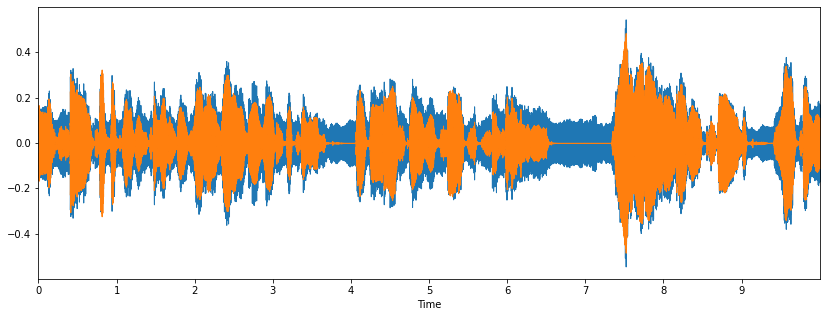

In [35]:
%matplotlib inline
import matplotlib.pyplot as plt
import librosa.display
import librosa
import IPython.display as ipd
plt.figure(figsize=(14, 5))
librosa.display.waveplot(x.numpy(), sr=48000)
librosa.display.waveplot(y.numpy(), sr=48000)

In [ ]:
!cp -R "/content/tfrecords/output" '/content/drive/MyDrive/tfrecords/outputs'

shell-init: error retrieving current directory: getcwd: cannot access parent directories: No such file or directory
cp: cannot stat '/content/tfrecords/output': No such file or directory


In [ ]:
%cd /content/tfrecords/output

/content/tfrecords/output


In [ ]:
!ls | wc -l

600
